In [819]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing

# Arguments

In [820]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,
        'correlation':0,

        'forward learning rate':0.01,
        'inverse learning rate':0.01,

        'forward training epochs':20000,
        'inverse training epochs':20000,

        'forward training criterion':nn.L1Loss(),
        'inverse training criterion':nn.L1Loss(),
        'testing criterion':nn.L1Loss(),
        
        'optimizer':torch.optim.Rprop,

        'percent inverse':0.65
        }

now = datetime.now()

# Data Prep

In [821]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [822]:
df = pd.read_excel('wide_range.xlsx')

spec = df.iloc[:,11:] 
temp = df.iloc[:,:11]

In [823]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,2.999482e-14,4.442183e-14,3.656011e-14,5.194757e-14,4.973315e-14,7.323828e-14,5.203014e-14,7.218750e-14,8.672268e-14,...,2.291410e-12,2.333930e-12,2.371461e-12,2.402093e-12,2.424702e-12,2.433566e-12,2.417632e-12,2.365972e-12,2.285583e-12,2.211520e-12
1,2.303472e-14,2.137935e-14,3.026088e-14,2.454882e-14,3.471853e-14,3.357273e-14,5.103051e-14,3.893226e-14,5.676652e-14,7.142763e-14,...,1.639899e-12,1.669825e-12,1.698490e-12,1.723560e-12,1.743375e-12,1.753393e-12,1.745497e-12,1.711668e-12,1.656824e-12,1.606307e-12
2,3.321009e-14,2.824623e-14,3.587004e-14,2.765798e-14,3.802290e-14,3.688717e-14,5.919539e-14,5.122215e-14,8.020764e-14,1.073738e-13,...,4.487510e-12,4.550427e-12,4.603621e-12,4.643395e-12,4.667637e-12,4.665521e-12,4.616247e-12,4.499595e-12,4.329608e-12,4.173042e-12
3,1.357453e-14,1.187304e-14,1.558260e-14,1.228372e-14,1.717658e-14,1.683286e-14,2.695498e-14,2.296024e-14,3.580425e-14,4.786284e-14,...,2.760638e-12,2.807683e-12,2.849087e-12,2.882405e-12,2.906159e-12,2.913462e-12,2.891133e-12,2.826217e-12,2.727201e-12,2.635977e-12
4,2.619885e-14,2.332198e-14,3.140154e-14,2.493494e-14,3.488262e-14,3.382589e-14,5.274100e-14,4.275298e-14,6.464003e-14,8.408254e-14,...,3.121194e-12,3.173340e-12,3.218273e-12,3.253581e-12,3.277914e-12,3.283670e-12,3.256076e-12,3.180625e-12,3.066965e-12,2.962253e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,3.291908e-14,2.904236e-14,3.868747e-14,3.052280e-14,4.249031e-14,4.114082e-14,6.427529e-14,5.247101e-14,7.966764e-14,1.038464e-13,...,3.492639e-12,3.541544e-12,3.586094e-12,3.622037e-12,3.646522e-12,3.650482e-12,3.617422e-12,3.531303e-12,3.402929e-12,3.284666e-12
2196,2.234104e-14,1.882600e-14,2.361172e-14,1.812234e-14,2.488261e-14,2.422053e-14,3.928364e-14,3.469407e-14,5.502010e-14,7.455935e-14,...,4.885042e-12,4.950908e-12,5.006120e-12,5.046707e-12,5.070411e-12,5.065506e-12,5.009465e-12,4.880432e-12,4.693737e-12,4.521797e-12
2197,2.847468e-14,2.408754e-14,3.030068e-14,2.326424e-14,3.189002e-14,3.105177e-14,5.022622e-14,4.412174e-14,6.973943e-14,9.391391e-14,...,2.505269e-12,2.542833e-12,2.578975e-12,2.609906e-12,2.632938e-12,2.641187e-12,2.622551e-12,2.565215e-12,2.476821e-12,2.395382e-12
2198,1.648649e-14,1.406005e-14,1.783686e-14,1.379136e-14,1.903271e-14,1.863127e-14,3.027923e-14,2.667106e-14,4.232606e-14,5.720658e-14,...,1.138944e-12,1.158522e-12,1.179434e-12,1.199129e-12,1.215649e-12,1.225428e-12,1.222663e-12,1.201639e-12,1.165695e-12,1.132607e-12


In [824]:
# scale spectrum data by 10^12
spec = spec.apply(lambda x: x*args['spec scale'])

In [825]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.029995,0.044422,0.036560,0.051948,0.049733,0.073238,0.052030,0.072187,0.086723,...,2.291410,2.333930,2.371461,2.402093,2.424702,2.433566,2.417632,2.365972,2.285583,2.211520
1,0.023035,0.021379,0.030261,0.024549,0.034719,0.033573,0.051031,0.038932,0.056767,0.071428,...,1.639899,1.669825,1.698490,1.723560,1.743375,1.753393,1.745497,1.711668,1.656824,1.606307
2,0.033210,0.028246,0.035870,0.027658,0.038023,0.036887,0.059195,0.051222,0.080208,0.107374,...,4.487510,4.550427,4.603621,4.643395,4.667637,4.665521,4.616247,4.499595,4.329608,4.173042
3,0.013575,0.011873,0.015583,0.012284,0.017177,0.016833,0.026955,0.022960,0.035804,0.047863,...,2.760638,2.807683,2.849087,2.882405,2.906159,2.913462,2.891133,2.826217,2.727201,2.635977
4,0.026199,0.023322,0.031402,0.024935,0.034883,0.033826,0.052741,0.042753,0.064640,0.084083,...,3.121194,3.173340,3.218273,3.253581,3.277914,3.283670,3.256076,3.180625,3.066965,2.962253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.032919,0.029042,0.038687,0.030523,0.042490,0.041141,0.064275,0.052471,0.079668,0.103846,...,3.492639,3.541544,3.586094,3.622037,3.646522,3.650482,3.617422,3.531303,3.402929,3.284666
2196,0.022341,0.018826,0.023612,0.018122,0.024883,0.024221,0.039284,0.034694,0.055020,0.074559,...,4.885042,4.950908,5.006120,5.046707,5.070411,5.065506,5.009465,4.880432,4.693737,4.521797
2197,0.028475,0.024088,0.030301,0.023264,0.031890,0.031052,0.050226,0.044122,0.069739,0.093914,...,2.505269,2.542833,2.578975,2.609906,2.632938,2.641187,2.622551,2.565215,2.476821,2.395382
2198,0.016486,0.014060,0.017837,0.013791,0.019033,0.018631,0.030279,0.026671,0.042326,0.057207,...,1.138944,1.158522,1.179434,1.199129,1.215649,1.225428,1.222663,1.201639,1.165695,1.132607


In [826]:
# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=spec.shape)
spec_noisy = spec + noise

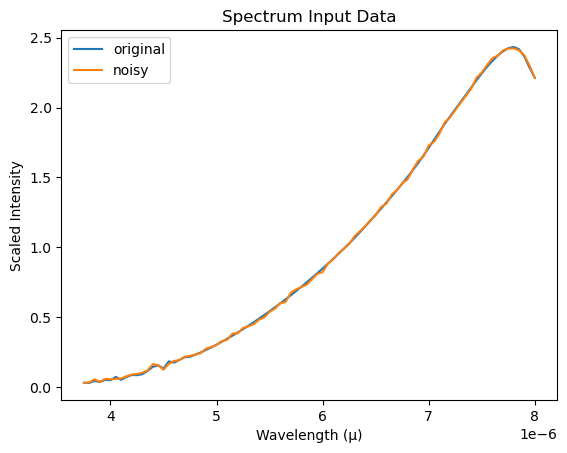

In [827]:
plt.title('Spectrum Input Data')
plt.plot(spec.iloc[0], label='original')
plt.plot(spec_noisy.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [828]:
# Normalize clean and noisy spectrum data
spec_scaler = preprocessing.StandardScaler()

spec_scaler.fit(spec)
spec_scaled = spec_scaler.transform(spec)
spec_unscaled = spec_scaler.inverse_transform(spec_scaled)

spec_scaler.fit(spec_noisy)
spec_noisy_scaled = spec_scaler.transform(spec_noisy)

spec_scaled_df = pd.DataFrame(spec_scaled, columns=spec.columns)
spec_noisy_scaled_df = pd.DataFrame(spec_noisy_scaled, columns = spec.columns)



# Normalize clean and temperature data
temp_scaler = preprocessing.StandardScaler()
temp_scaler.fit(temp)
temp_scaled = temp_scaler.transform(temp)
temp_unscaled = temp_scaler.inverse_transform(temp_scaled)

temp_unscaled_df = pd.DataFrame(temp_unscaled, columns=temp.columns)
temp_scaled_df = pd.DataFrame(temp_scaled, columns=temp.columns)


/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


In [829]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.029995,0.044422,0.036560,0.051948,0.049733,0.073238,0.052030,0.072187,0.086723,...,2.291410,2.333930,2.371461,2.402093,2.424702,2.433566,2.417632,2.365972,2.285583,2.211520
1,0.023035,0.021379,0.030261,0.024549,0.034719,0.033573,0.051031,0.038932,0.056767,0.071428,...,1.639899,1.669825,1.698490,1.723560,1.743375,1.753393,1.745497,1.711668,1.656824,1.606307
2,0.033210,0.028246,0.035870,0.027658,0.038023,0.036887,0.059195,0.051222,0.080208,0.107374,...,4.487510,4.550427,4.603621,4.643395,4.667637,4.665521,4.616247,4.499595,4.329608,4.173042
3,0.013575,0.011873,0.015583,0.012284,0.017177,0.016833,0.026955,0.022960,0.035804,0.047863,...,2.760638,2.807683,2.849087,2.882405,2.906159,2.913462,2.891133,2.826217,2.727201,2.635977
4,0.026199,0.023322,0.031402,0.024935,0.034883,0.033826,0.052741,0.042753,0.064640,0.084083,...,3.121194,3.173340,3.218273,3.253581,3.277914,3.283670,3.256076,3.180625,3.066965,2.962253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.032919,0.029042,0.038687,0.030523,0.042490,0.041141,0.064275,0.052471,0.079668,0.103846,...,3.492639,3.541544,3.586094,3.622037,3.646522,3.650482,3.617422,3.531303,3.402929,3.284666
2196,0.022341,0.018826,0.023612,0.018122,0.024883,0.024221,0.039284,0.034694,0.055020,0.074559,...,4.885042,4.950908,5.006120,5.046707,5.070411,5.065506,5.009465,4.880432,4.693737,4.521797
2197,0.028475,0.024088,0.030301,0.023264,0.031890,0.031052,0.050226,0.044122,0.069739,0.093914,...,2.505269,2.542833,2.578975,2.609906,2.632938,2.641187,2.622551,2.565215,2.476821,2.395382
2198,0.016486,0.014060,0.017837,0.013791,0.019033,0.018631,0.030279,0.026671,0.042326,0.057207,...,1.138944,1.158522,1.179434,1.199129,1.215649,1.225428,1.222663,1.201639,1.165695,1.132607


In [830]:
spec_unscaled

array([[0.03105584, 0.02999482, 0.04442183, ..., 2.36597201, 2.28558255,
        2.21152006],
       [0.02303472, 0.02137935, 0.03026088, ..., 1.71166774, 1.65682389,
        1.60630741],
       [0.03321009, 0.02824623, 0.03587004, ..., 4.49959521, 4.32960797,
        4.17304151],
       ...,
       [0.02847468, 0.02408754, 0.03030068, ..., 2.56521541, 2.47682096,
        2.39538243],
       [0.01648649, 0.01406005, 0.01783686, ..., 1.20163893, 1.16569548,
        1.13260748],
       [0.02009135, 0.01711356, 0.02174333, ..., 4.45698039, 4.28885161,
        4.13399539]])

In [831]:
spec_noisy_scaled_df    

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.376580,0.804184,1.434487,0.853516,1.322048,1.304659,0.287226,1.113064,0.622938,0.324040,...,-0.302851,-0.293700,-0.305537,-0.298774,-0.304469,-0.308372,-0.305614,-0.291693,-0.286203,-0.295480
1,0.035467,-0.001289,-0.370307,0.233330,0.018040,0.473204,0.343123,-0.032542,-1.229809,-1.002945,...,-0.793974,-0.783460,-0.790331,-0.801724,-0.803309,-0.795372,-0.804700,-0.800043,-0.795350,-0.807607
2,1.296902,0.587912,-0.544977,0.059676,-0.877385,1.141332,-0.346831,0.381820,0.890550,0.784166,...,1.307345,1.300868,1.314768,1.296632,1.312297,1.313567,1.298457,1.320322,1.323997,1.301333
3,-0.114369,0.418208,-0.747452,-0.785636,-1.513356,-1.630765,-0.341108,-1.492162,-0.916379,-1.446837,...,0.028604,0.056892,0.031966,0.044003,0.033584,0.032474,0.050133,0.047652,0.076421,0.064097
4,-0.629874,0.558216,-0.743625,-0.722288,-0.872028,0.084328,0.328940,0.327348,-0.034604,0.372031,...,0.296541,0.310030,0.310847,0.319292,0.309344,0.306759,0.309601,0.308668,0.308238,0.309948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,1.588374,1.318253,0.525875,0.674876,0.900549,2.082521,1.256359,1.042310,0.407868,0.886953,...,0.574551,0.579546,0.580726,0.563723,0.581186,0.572636,0.575583,0.586721,0.579744,0.585499
2196,0.218204,-1.860846,0.349614,-0.568359,-0.464005,-0.599012,0.008091,-1.566152,0.385827,-0.525698,...,1.606767,1.602760,1.598967,1.601117,1.601316,1.605561,1.589544,1.598198,1.595411,1.605414
2197,1.322568,0.180497,-0.057189,-0.711703,0.251089,0.479247,-0.721158,-0.662277,1.172678,0.607911,...,-0.148228,-0.163918,-0.155758,-0.161982,-0.154132,-0.150422,-0.152003,-0.152255,-0.144102,-0.146749
2198,-0.797923,-0.985524,-1.678548,-1.943129,-1.064586,0.067135,-1.073708,-0.888475,-0.901790,-0.430875,...,-1.165908,-1.173582,-1.175136,-1.180192,-1.174377,-1.182658,-1.170732,-1.168914,-1.169620,-1.183049


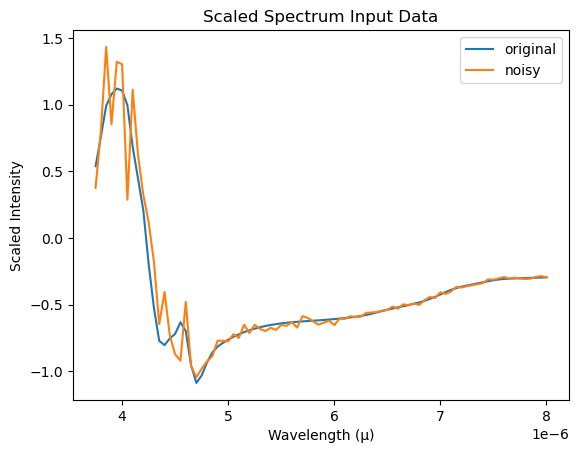

In [832]:
plt.title('Scaled Spectrum Input Data')
plt.plot(spec_scaled_df.iloc[0], label='original')
plt.plot(spec_noisy_scaled_df.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

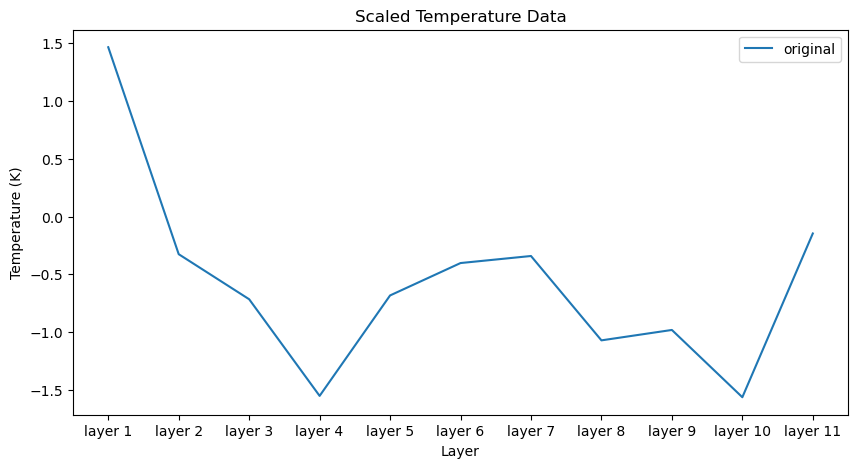

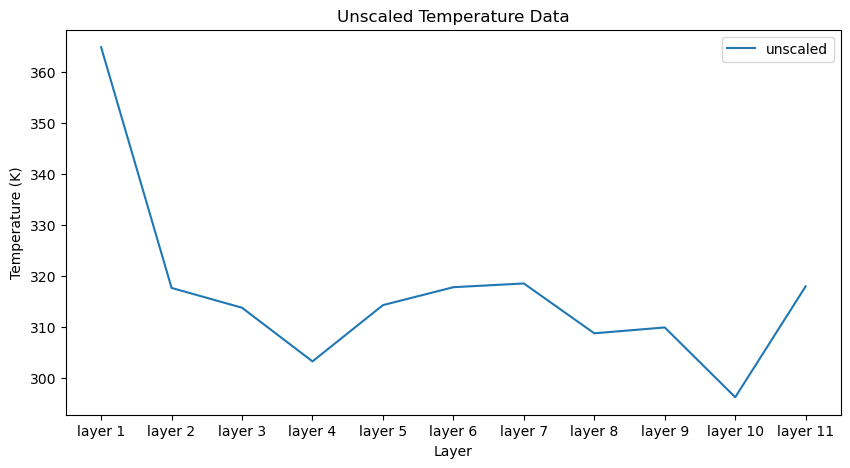

In [833]:
plt.figure(figsize=(10, 5))
plt.title('Scaled Temperature Data')
plt.plot(temp_scaled_df.iloc[0], label='original')
plt.xlabel("Layer")
plt.ylabel("Temperature (K)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Unscaled Temperature Data')
plt.plot(temp_unscaled_df.iloc[0], label='unscaled')
plt.xlabel("Layer")
plt.ylabel("Temperature (K)")
plt.legend()
plt.show()

In [834]:
spec_train_df, spec_test_df, temp_train_df, temp_test_df = train_test_split(spec_noisy_scaled_df, temp_scaled_df, train_size=args['percent training data'], random_state=101)

spec_train = df_to_tensor(spec_train_df)
spec_test = df_to_tensor(spec_test_df)
temp_train = df_to_tensor(temp_train_df)
temp_test = df_to_tensor(temp_test_df)

In [835]:
# Feature Selection

In [836]:
spec_train

tensor([[ 2.4309,  1.3482,  1.8731,  ...,  0.7087,  0.6977,  0.7172],
        [ 0.9489,  2.1889,  0.4056,  ..., -0.2874, -0.2868, -0.2749],
        [-1.0958, -0.4950, -1.2342,  ..., -0.6809, -0.6759, -0.6659],
        ...,
        [ 1.5902,  1.8491,  2.2282,  ...,  1.9248,  1.9238,  1.9324],
        [-1.2903,  0.0954, -1.0781,  ..., -0.0941, -0.1011, -0.0748],
        [-1.3900, -0.3450, -0.7408,  ...,  0.5131,  0.5109,  0.5194]])

In [837]:
temp_train

tensor([[ 1.6615,  0.3224,  0.2405,  ...,  0.8711,  0.5277,  0.7822],
        [ 1.2537, -0.1200,  0.9234,  ...,  1.0402,  1.2832, -0.1334],
        [-0.6808, -1.6187, -0.2295,  ..., -1.6795, -1.9369, -0.5915],
        ...,
        [ 1.6574,  1.0373,  0.5903,  ...,  1.6193,  2.3167,  1.6640],
        [-0.5003, -0.1864, -1.3273,  ...,  0.8319, -0.6895,  0.0680],
        [ 0.5417, -1.0197, -2.0095,  ...,  0.0320, -1.2214,  0.6283]])

# Model Design

In [838]:
class ForwardNet(nn.Module):
    def __init__(self, middle_size, io_size):
        super(ForwardNet, self).__init__()
        self.lin1 = nn.Linear(middle_size, 60)
        self.lin2 = nn.Linear(60, 45)
        self.lin3 = nn.Linear(45, 30)
        self.lin4 = nn.Linear(30, 30)
        self.lin5 = nn.Linear(30, 30)
        self.lin_fin = nn.Linear(30, io_size)


    def forward(self, temp):
        x = F.leaky_relu(self.lin1(temp))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_spec = self.lin_fin(x)
        return pred_spec

In [839]:
class InverseNet(nn.Module):
    def __init__(self, io_size, middle_size):
        super(InverseNet, self).__init__()
        self.lin1 = nn.Linear(io_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin5 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, middle_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_temp = self.lin_fin(x)
        return pred_temp

In [840]:
class TandemNet(nn.Module):
    def __init__(self, forward_model, inverse_model):
        super(TandemNet, self).__init__()
        self.forward_model = forward_model
        self.inverse_model = inverse_model

    def forward(self, spec_train):
        pred_temp = self.inverse_model(spec_train)
        pred_spec = self.forward_model(pred_temp)
        return pred_temp, pred_spec

In [841]:
_, middle_size = temp.shape
_, io_size = spec_noisy_scaled_df.shape

# define variables for each model
forward_model = ForwardNet(middle_size, io_size)
inverse_model = InverseNet(io_size, middle_size)
tandem_net = TandemNet(forward_model, inverse_model)


x = torch.rand(1540, io_size)
print(forward_model(inverse_model(x)).shape)
pred_temp_x, pred_spec_x = tandem_net(x)
print(pred_spec_x.shape)

torch.Size([1540, 86])
torch.Size([1540, 86])


# Training Loop

In [842]:
def train_forward_model(forward_model, temp_train):
    print('FORWARD MODEL TRAINING')

    forward_loss_list = []
    forward_loss_sum = 0

    num_forward_epochs = args['forward training epochs']
    criterion = args['forward training criterion']
    optimizer = args['optimizer'](forward_model.parameters(), lr=args['forward learning rate'])

    for epoch in range(num_forward_epochs):
        # forward pass and loss
        pred_spec = forward_model(temp_train)
        loss = criterion(spec_train, pred_spec)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            forward_loss_sum += loss.item()

        forward_loss_list.append(loss.item())

        if (epoch + 1) % (num_forward_epochs / 10) == 0:
            print(f'forward epoch: {epoch + 1}, forward loss = {loss}')

    avg_forward_loss = forward_loss_sum / (num_forward_epochs - 100)
    print(f'\nAVERAGE FORWARD LOSS: {avg_forward_loss}')

    return forward_loss_list
        

In [843]:
def train_inverse_model(tandem_net, spec_train):
    print('\nINVERSE MODEL TRAINING')

    # Fix the parameters of the forward model
    for param in forward_model.parameters():
        param.requires_grad = False

    tandem_loss_list = []
    inverse_loss_list = []
    
    tandem_loss_sum = 0

    num_inverse_epochs = args['inverse training epochs']
    criterion = args['inverse training criterion']
    optimizer = args['optimizer'](tandem_net.parameters(), lr=args['inverse learning rate'])
    percent_inverse = args['percent inverse']

    for epoch in range(num_inverse_epochs):
        # pass through tandem model and calculate both inverse and tandem losses
        pred_temp, pred_spec = tandem_net(spec_train)
        inverse_loss = criterion(temp_train, pred_temp)
        tandem_loss = criterion(spec_train, pred_spec)

        # empty gradients
        optimizer.zero_grad()

        # for first chunk of epochs, train tandem network
        if epoch < (num_inverse_epochs * (1 - percent_inverse)):
            tandem_loss.backward()

        # for second chunk of epochs, train inverse network
        else:
            inverse_loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            tandem_loss_sum += tandem_loss.item()

        tandem_loss_list.append(tandem_loss.item())
        inverse_loss_list.append(inverse_loss.item())

        if (epoch + 1) % (num_inverse_epochs / 10) == 0:
            print(f'forward epoch: {epoch + 1}, tandem loss = {tandem_loss}, inverse loss = {inverse_loss}')

    avg_inverse_loss = tandem_loss_sum / (num_inverse_epochs - 100)
    print(f'\nAVERAGE INVERSE LOSS: {avg_inverse_loss}')
    
    return tandem_loss_list, inverse_loss_list

In [844]:
forward_loss_list = train_forward_model(forward_model, temp_train)
tandem_loss_list, inverse_loss_list = train_inverse_model(tandem_net, spec_train)

FORWARD MODEL TRAINING
forward epoch: 2000, forward loss = 0.08701114356517792
forward epoch: 4000, forward loss = 0.08652450889348984
forward epoch: 6000, forward loss = 0.08640626817941666
forward epoch: 8000, forward loss = 0.08636680990457535
forward epoch: 10000, forward loss = 0.08630302548408508
forward epoch: 12000, forward loss = 0.08625361323356628
forward epoch: 14000, forward loss = 0.08618944138288498
forward epoch: 16000, forward loss = 0.08614145964384079
forward epoch: 18000, forward loss = 0.08610422164201736
forward epoch: 20000, forward loss = 0.08606666326522827

AVERAGE FORWARD LOSS: 0.08651992496159208

INVERSE MODEL TRAINING
forward epoch: 2000, tandem loss = 0.08633923530578613, inverse loss = 0.7035194039344788
forward epoch: 4000, tandem loss = 0.08619130402803421, inverse loss = 0.7034996747970581
forward epoch: 6000, tandem loss = 0.08606840670108795, inverse loss = 0.7032454013824463
forward epoch: 8000, tandem loss = 0.09760352969169617, inverse loss = 0.3

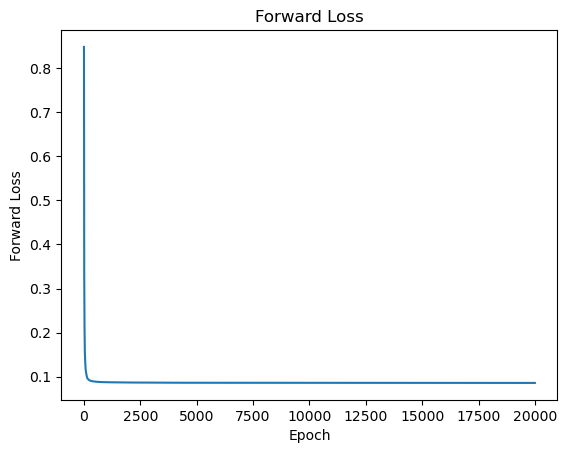

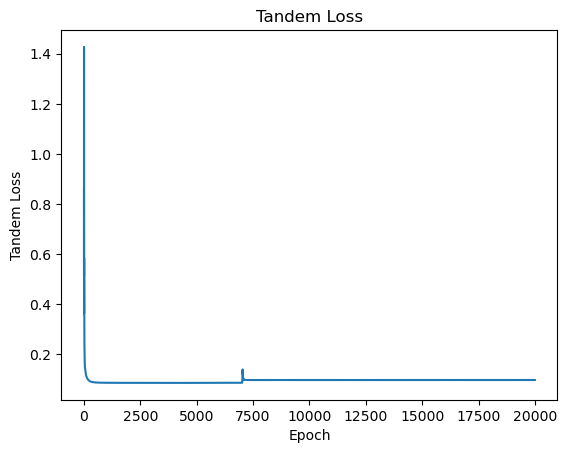

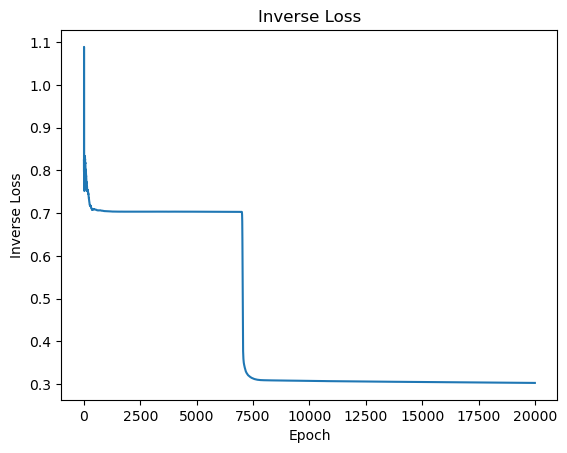

In [845]:
# plot forward loss
plt.plot(forward_loss_list)

plt.title("Forward Loss")
plt.xlabel("Epoch")
plt.ylabel("Forward Loss")
plt.show()


# plot tandem loss
plt.plot(tandem_loss_list)

plt.title("Tandem Loss")
plt.xlabel("Epoch")
plt.ylabel("Tandem Loss")
plt.show()

# plot inverse loss
plt.plot(inverse_loss_list)

plt.title("Inverse Loss")
plt.xlabel("Epoch")
plt.ylabel("Inverse Loss")
plt.show()

# Testing

In [846]:
pred_temp, pred_spec = tandem_net(spec_test)

In [847]:
# unscale data appropriately
pred_temp = temp_scaler.inverse_transform(pred_temp.detach().numpy())
pred_spec = spec_scaler.inverse_transform(pred_spec.detach().numpy())
spec_test = spec_scaler.inverse_transform(spec_test.detach().numpy())
temp_test = temp_scaler.inverse_transform(temp_test.detach().numpy())

In [848]:
pred_temp

array([[301.9565 , 324.66718, 328.78348, ..., 320.40793, 315.90503,
        296.46463],
       [366.31924, 344.08475, 340.10144, ..., 322.33334, 317.3297 ,
        273.94562],
       [293.91068, 312.81726, 311.05008, ..., 322.40262, 329.18066,
        340.9823 ],
       ...,
       [321.3382 , 319.46274, 319.0187 , ..., 319.77667, 327.4509 ,
        291.97018],
       [297.13998, 305.10675, 309.3955 , ..., 337.19165, 344.38788,
        338.92926],
       [348.75424, 325.55692, 323.83755, ..., 326.8681 , 327.6232 ,
        303.20377]], dtype=float32)

In [849]:
pred_spec

array([[0.01889793, 0.01568352, 0.01939238, ..., 1.5261784 , 1.479263  ,
        1.4276124 ],
       [0.03962414, 0.03725238, 0.05376608, ..., 0.87505275, 0.8546099 ,
        0.8319434 ],
       [0.01696217, 0.01463052, 0.02004768, ..., 3.4333818 , 3.3132298 ,
        3.178589  ],
       ...,
       [0.0194357 , 0.01668642, 0.02169164, ..., 1.3666707 , 1.3217628 ,
        1.2889419 ],
       [0.02147955, 0.01763195, 0.02244708, ..., 3.349141  , 3.221927  ,
        3.1173205 ],
       [0.02938441, 0.0267385 , 0.03774012, ..., 1.7751069 , 1.7203864 ,
        1.6698667 ]], dtype=float32)

In [850]:
temp_test

array([[303.54623, 306.86285, 318.00604, ..., 316.4249 , 320.6739 ,
        295.2881 ],
       [371.26633, 341.55963, 327.97256, ..., 324.5002 , 302.25323,
        275.25125],
       [309.39462, 295.16428, 300.03394, ..., 325.8748 , 329.4067 ,
        340.45575],
       ...,
       [308.55194, 299.23154, 315.24008, ..., 326.24756, 322.19202,
        293.00247],
       [283.59058, 310.967  , 327.08307, ..., 332.6732 , 346.84286,
        338.84494],
       [346.87994, 337.78955, 315.88126, ..., 324.88202, 326.0698 ,
        303.86047]], dtype=float32)

In [851]:
spec_test

array([[0.01153708, 0.01267651, 0.02014993, ..., 1.5243987 , 1.47745   ,
        1.4186851 ],
       [0.03357442, 0.05024795, 0.04407673, ..., 0.9666036 , 0.93919104,
        0.9125806 ],
       [0.01657722, 0.01734332, 0.02137535, ..., 3.4593482 , 3.3367198 ,
        3.2374482 ],
       ...,
       [0.01766344, 0.0123144 , 0.01436857, ..., 1.426671  , 1.4170955 ,
        1.354544  ],
       [0.02254107, 0.01043998, 0.02914838, ..., 3.3690464 , 3.245571  ,
        3.1190667 ],
       [0.03734883, 0.0154654 , 0.02073177, ..., 1.8021961 , 1.7515558 ,
        1.6969327 ]], dtype=float32)

In [852]:
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

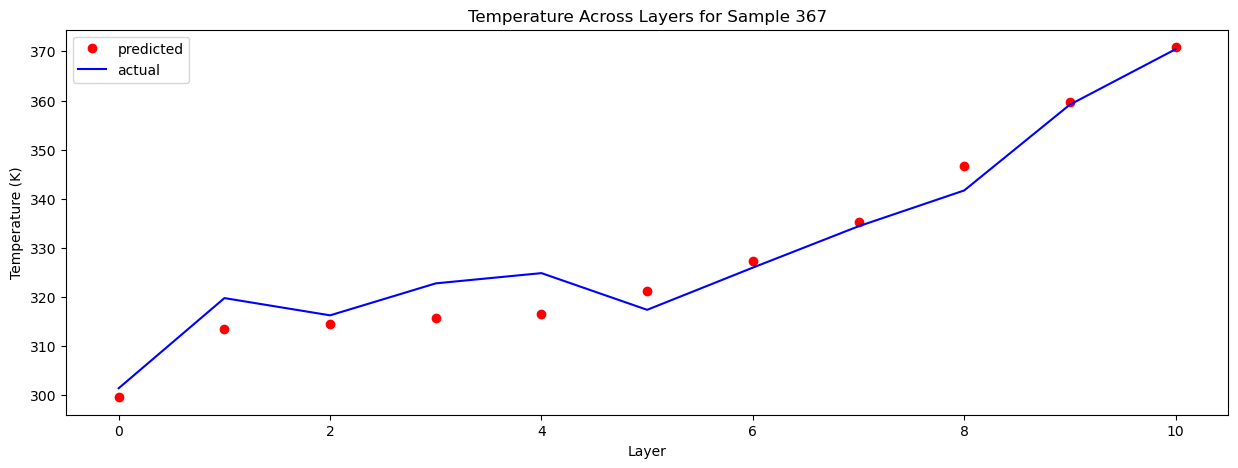

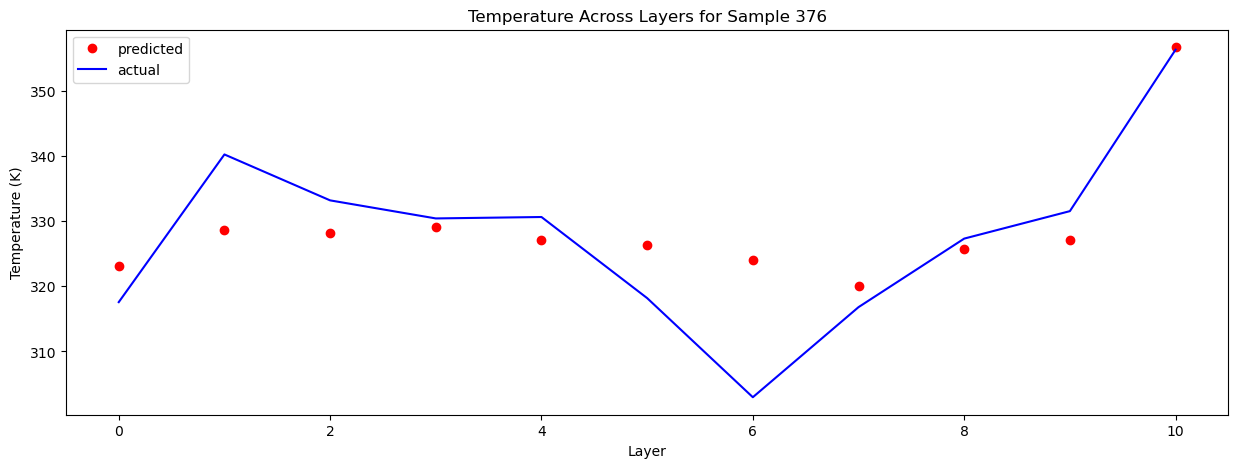

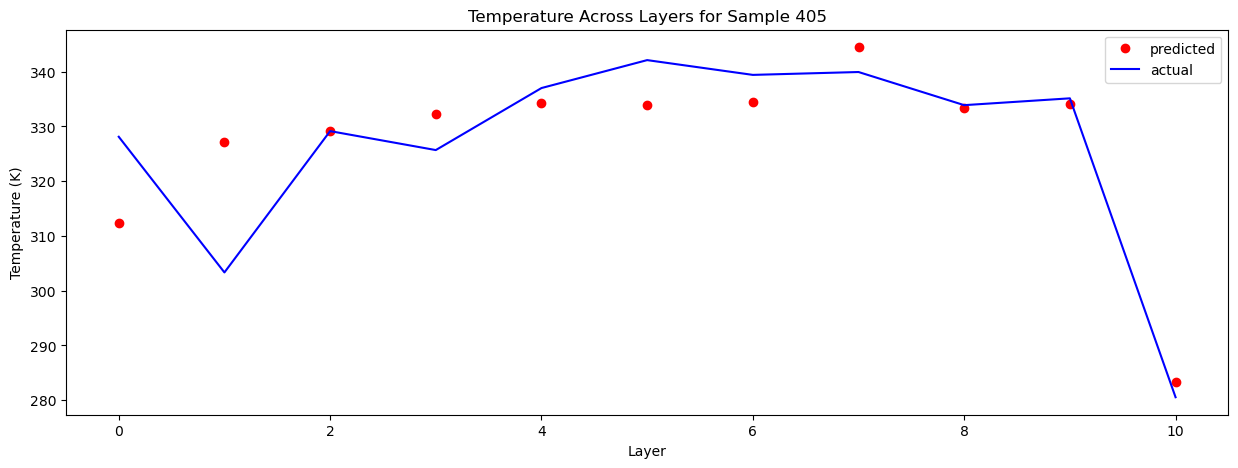

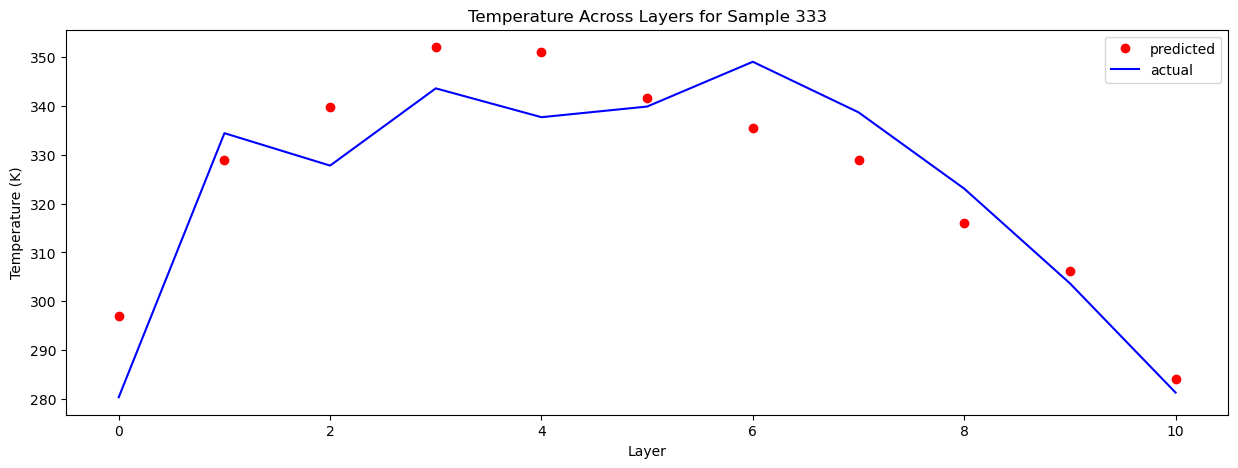

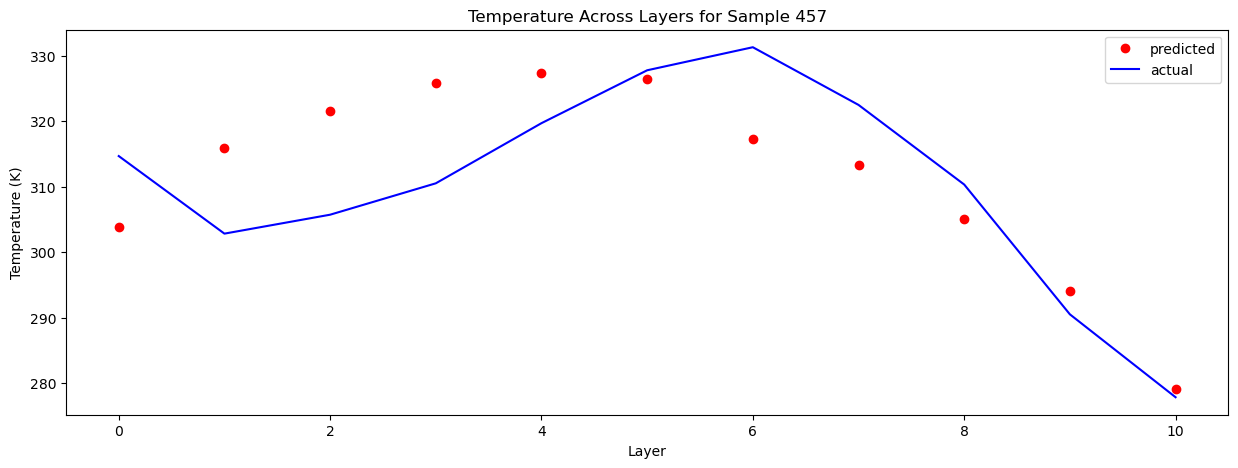

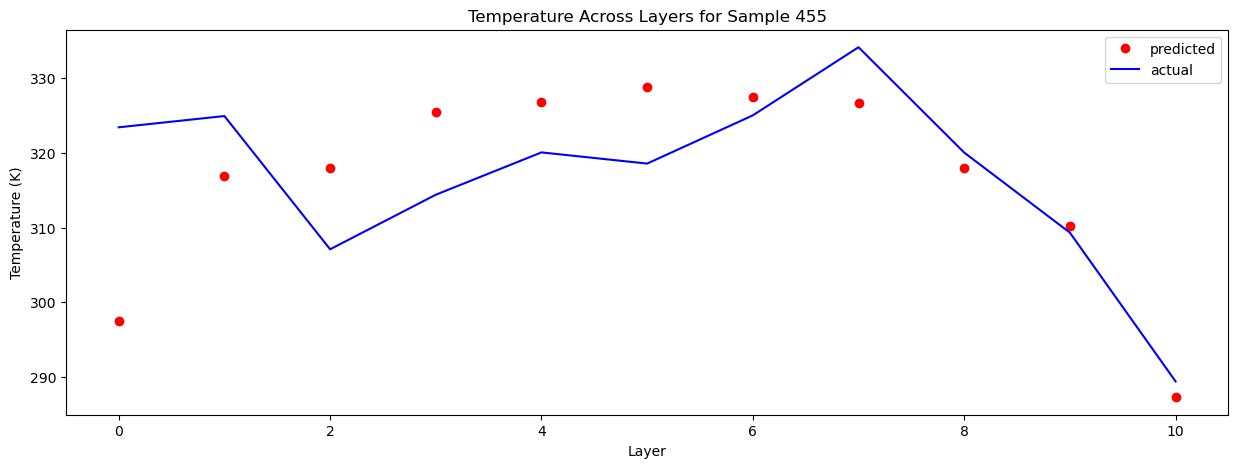

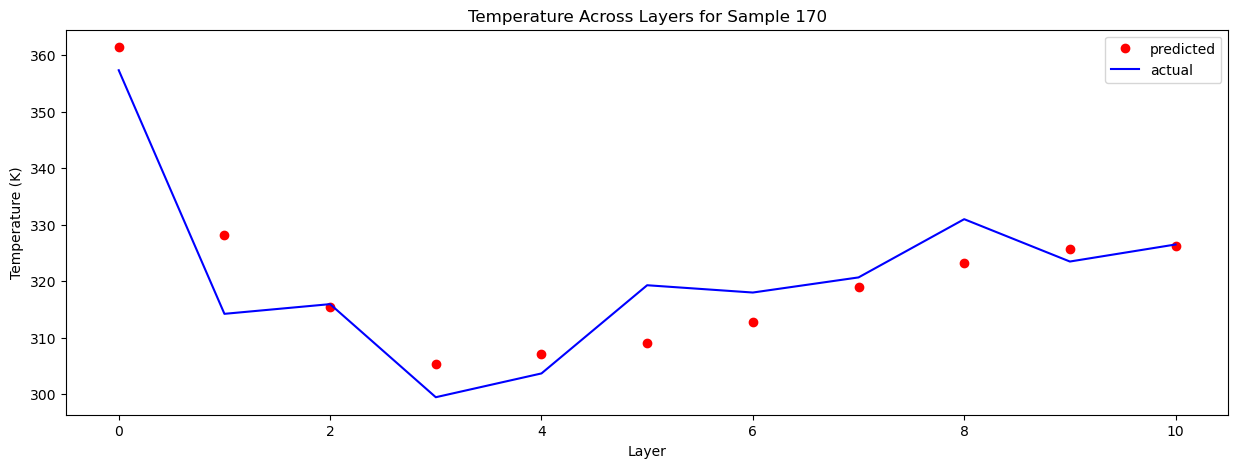

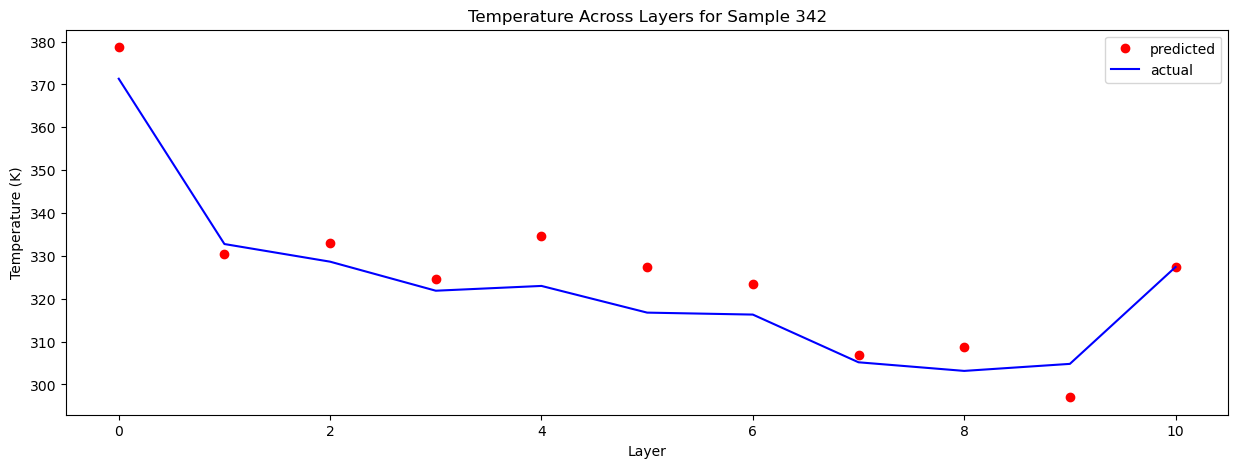

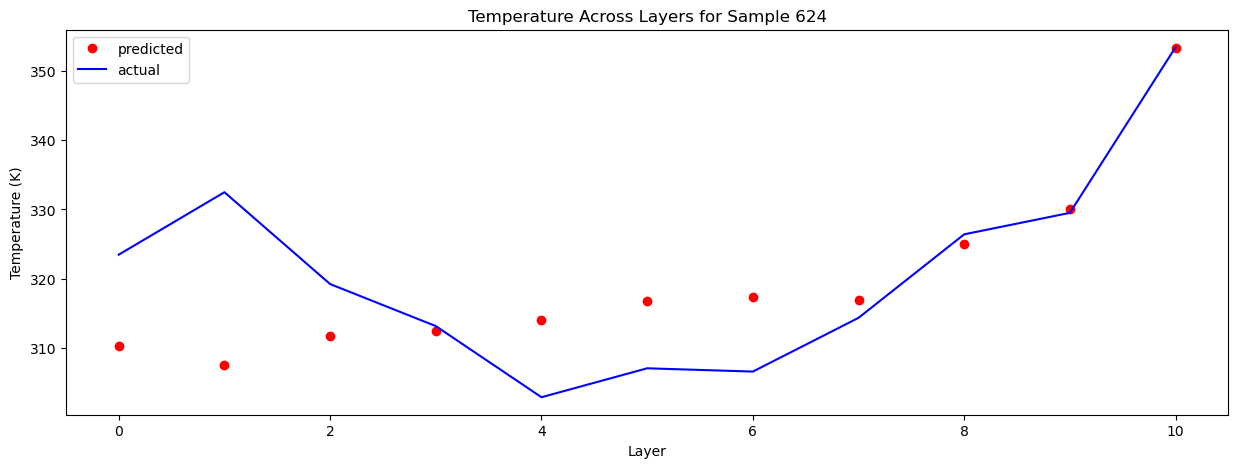

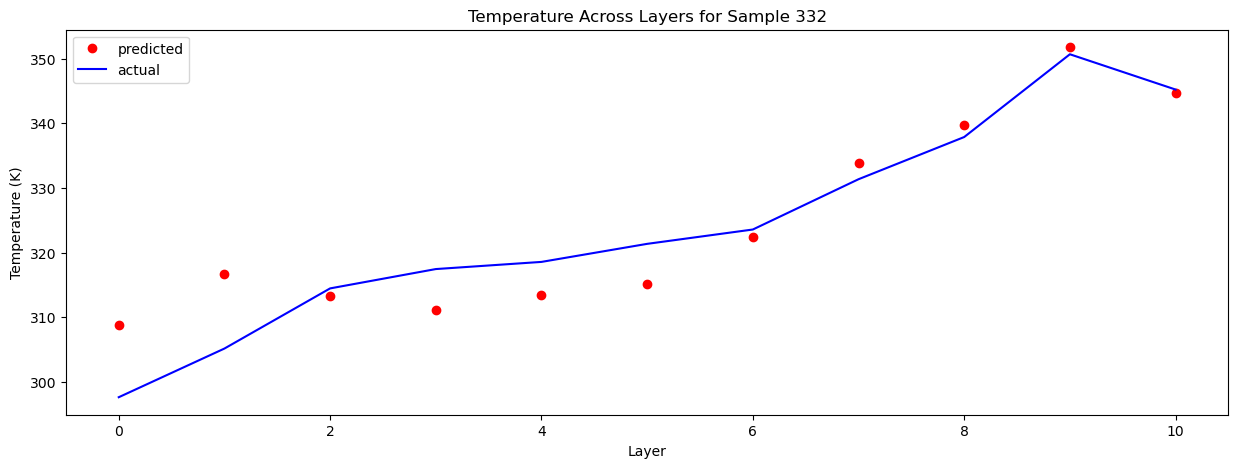

In [858]:
# plot spectrum --> temperature error
import random
num_graphs = 10
indices = []

with torch.no_grad():
    for i in range(0, num_graphs):
        n = random.randint(0, len(pred_temp))
        indices.append(n)

    for index in indices:
        plot_test_results(pred_temp[index], temp_test[index], index)
